## Generate Figure 1 for "Existence of phase-cohesive solutions of the lossless power flow equations".

In [1]:
import numpy as np
import networkx as nx
from scipy.optimize import fsolve
from numpy.linalg import eigvalsh
import matplotlib.pyplot as plt
import matplotlib as mpl

The IEEE Case 14 test grid from matpower. All data is in MW.

In [2]:
# Nodes and edges
nodes = np.arange(1, 14)
edges = [
    (1, 2), (1, 5), (2, 3), (2, 4), (2, 5),
    (3, 4), (4, 5), (4, 7), (4, 9), (5, 6),
    (6, 11), (6, 12), (6, 13), (7, 8), (7, 9),
    (9, 10), (9, 14), (10, 11), (12, 13), (13, 14)
]

# Matrix of susceptances (in MW) -- uniform susceptance, which supports multistability, for all edges:
# (other options that support multistability: 51.66, 110.14, 135.95, 136.76, 153.57)
Bvec = np.array([110.14 for _ in range(len(edges))])
Bdiag = np.diag(Bvec)
Bdiag_inv = np.diag(1/Bvec)

# Vector of power injections p
pvec = np.array([
    219.0000,
    18.3000,
   -94.2000,
   -47.8000,
    -7.6000,
   -11.2000,
          0,
          0,
   -29.5000,
    -9.0000,
    -3.5000,
    -6.1000,
   -13.5000,
   -14.9000,
])

# Size of the network
Nv = pvec.size
Ne = Bvec.size
Nc = Ne-Nv+1

# The node-edge incidence matrix
E = np.zeros([Nv,Ne])
for e in range(Ne):
    f = edges[e][0]-1
    t = edges[e][1]-1
    E[f,e] = +1.0
    E[t,e] = -1.0

# The cycle-edge incidence matrix
C = np.zeros([Ne,Nc])
c = [0, -1, 5]
C[0,0]=1; C[1,0]=-1; C[4,0]=1
C[11,1]=1; C[12,1]=-1; C[18,1]=1
C[3,2]=1; C[4,2]=-1; C[6,2]=1
C[2,3]=1; C[3,3]=-1; C[5,3]=1
C[7,4]=1; C[8,4]=-1; C[14,4]=1
C[6,5]=1; C[9,5]=1; C[10,5]=1; C[8,5]=-1; C[15,5]=-1; C[17,5]=-1
C[10,6]=1; C[12,6]=-1; C[15,6]=-1; C[16,6]=1; C[17,6]=-1; C[19,6]=-1

Build a networkx graph for plotting. Nodes have power attribudes, edges have susceptance attributes.

In [3]:
G = nx.Graph()

for node, p in zip(nodes, pvec):
    G.add_node(node, p=p)

for (edge, b) in zip(edges, Bvec):
    G.add_edge(edge[0], edge[1], b=b)

Plot the network topology

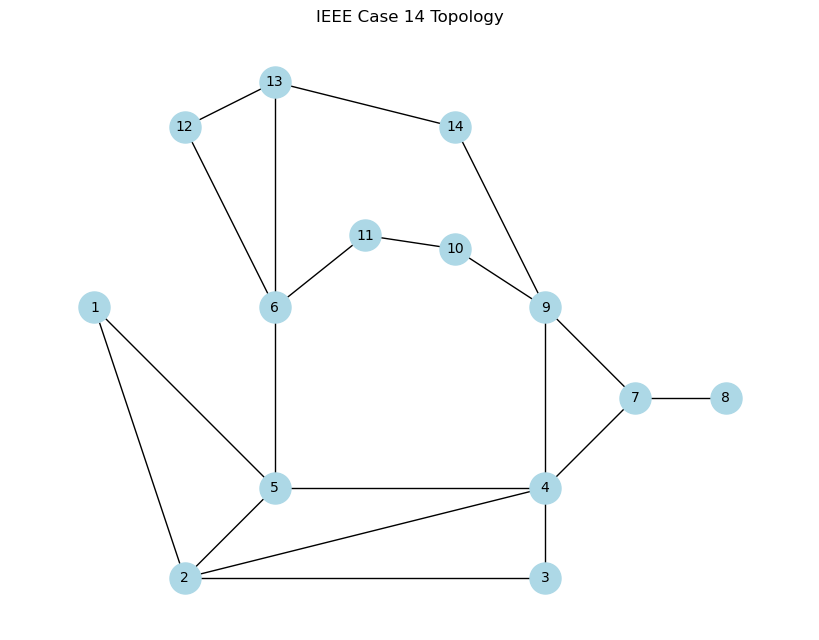

In [4]:
# Define node positions
coordinates = [
    (2,8),
    (4,2),
    (12,2),
    (12,4),
    (6,4),
    (6,8),
    (14,6),
    (16,6),
    (12,8),
    (10,9.3),
    (8,9.6),
    (4,12),
    (6,13),
    (10,12)
]
positions = {i + 1: (x, y) for i, (x, y) in enumerate(coordinates)}

plt.figure(figsize=(8, 6))
nx.draw(G, pos=positions, with_labels=True, node_color='lightblue', node_size=500, font_size=10)
plt.title("IEEE Case 14 Topology")
plt.axis("equal")
plt.show()


Plot the power injections and line susceptances

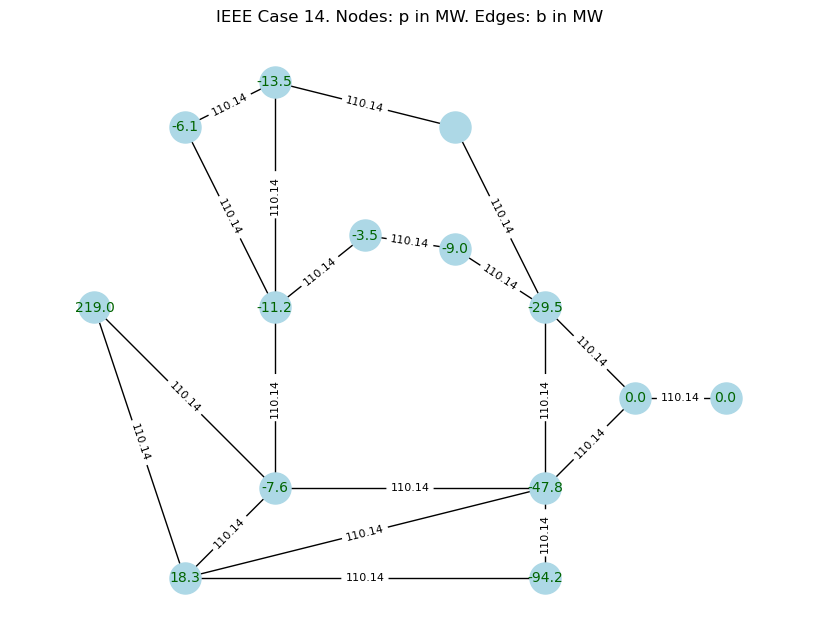

In [5]:
plt.figure(figsize=(8, 6))

# Draw nodes and edges only (no labels)
nx.draw(
    G,
    pos=positions,
    node_color='lightblue',
    node_size=500,
    font_size=10,
    with_labels=False
)

# Draw edge labels for 'b'
edge_labels = {(u, v): f'{d["b"]:.2f}' for u, v, d in G.edges(data=True) if "b" in d}
nx.draw_networkx_edge_labels(G, pos=positions, edge_labels=edge_labels, font_size=8)

# Draw node labels using 'p' values only
node_labels = {n: f'{d["p"]:.1f}' for n, d in G.nodes(data=True) if "p" in d}
nx.draw_networkx_labels(G, pos=positions, labels=node_labels, font_size=10, font_color="darkgreen")

# Flip y-axis
plt.title("IEEE Case 14. Nodes: p in MW. Edges: b in MW")
plt.axis("equal")
plt.show()

Draw the fundamental cycles of the network

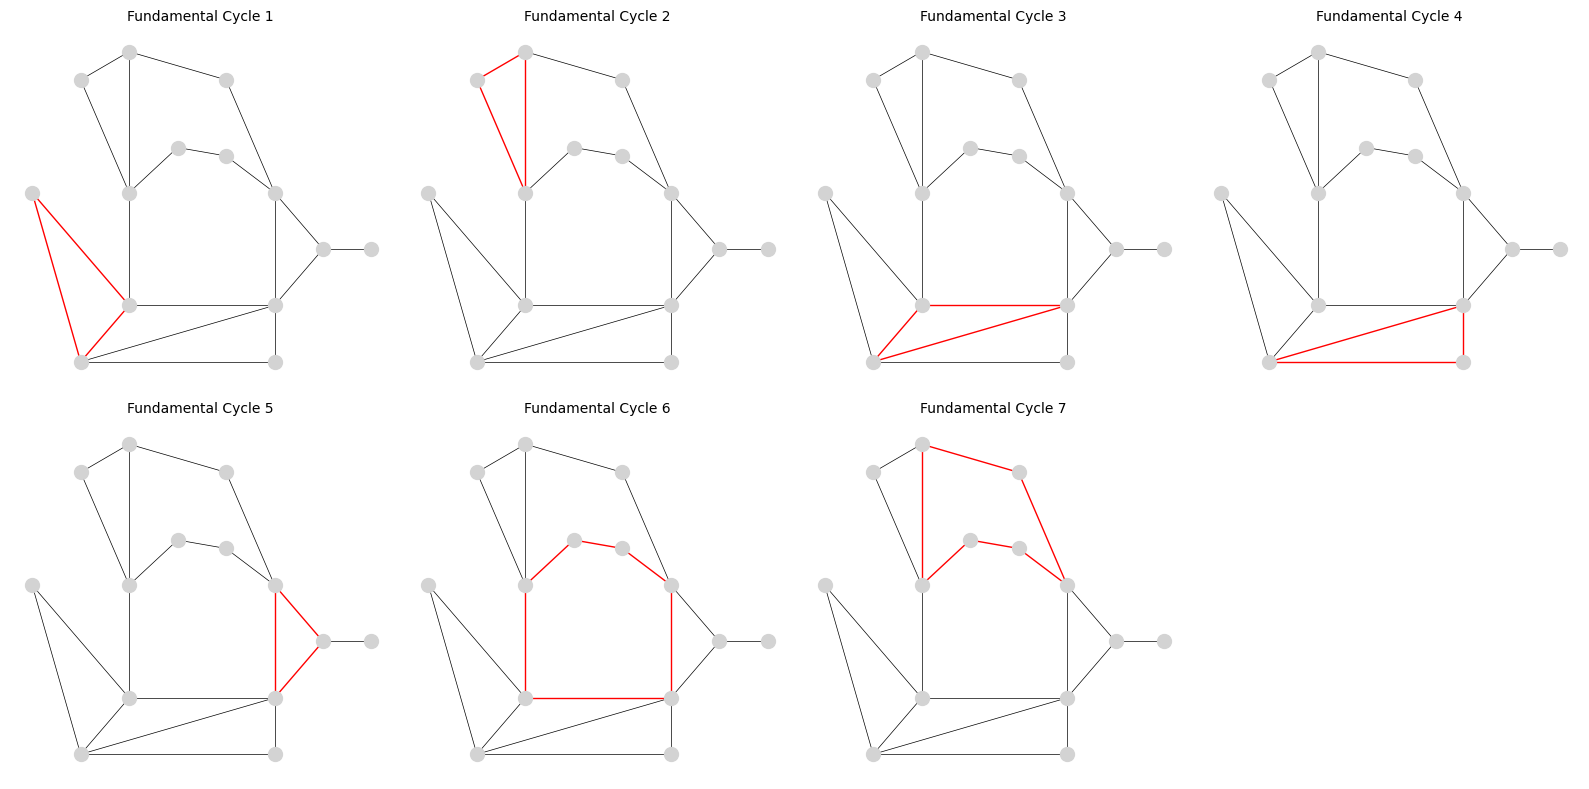

In [6]:
# Prepare figure with 8 subplots: 2 rows, 4 columns
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

# Loop over all fundamental cycles to visualize each one separately:
for i in range(Nc):
    
    ax = axes[i]
    ax.set_title(f'Fundamental Cycle {i+1}', fontsize=10)

    # Draw the nodes without node labels:
    nx.draw_networkx_nodes(G, pos=positions, ax=ax, node_size=100, node_color='lightgrey')
    
    # Draw edges one by one:
    for e in range(G.number_of_edges()):
        
        # The terminal ends of the edge for plotting:
        u = edges[e][0]
        v = edges[e][1]

        # Plot edge with color depending on whether the edge belongs to the respective cycle:
        if C[e,i] == 0:
            nx.draw_networkx_edges(G, pos = positions, ax=ax, edgelist=[(u, v)], edge_color='black', width=0.5)
        else:
            nx.draw_networkx_edges(G, pos = positions, ax=ax, edgelist=[(u, v)], edge_color='red', width=1)

    # Turn off axis and labels
    ax.axis('off')

ax = axes[Nc]
ax.axis('off')

plt.tight_layout()
plt.show()

Calculate power flow

In [7]:
# Power Flow Residual Function: -Pi + sum_j (B_ij * sin(theta_i - theta_j)) == 0
def power_flow_residuals(theta, pvec, edges, Bvec):
    residual = np.zeros(len(pvec))
    for e, (u, v) in enumerate(edges):
        theta_u = theta[u - 1]  # node indices start from 1 so we adjust it
        theta_v = theta[v - 1]
        flow = Bvec[e] * np.sin(theta_u - theta_v)
        residual[u - 1] -= flow
        residual[v - 1] += flow
    return residual - pvec

# Set slack bus to 0
slack_idx = 0  
variable_indices = [i for i in range(Nv) if i != slack_idx]

# Modified Residuals (excluding slack bus)
def reduced_residual(theta_red, pvec, edges, Bvec, Nv, slack_idx):
    theta = np.zeros(Nv)
    theta[variable_indices] = theta_red
    theta[slack_idx] = 0 

    return power_flow_residuals(theta, pvec, edges, Bvec)[variable_indices]

theta0 = np.zeros(Nv - 1)  # initial guess, excluding slack
theta_red_sol = fsolve(reduced_residual, theta0, args=(pvec, edges, Bvec, Nv, slack_idx))

# Reconstruct full theta vector
theta_base = np.zeros(Nv)
theta_base[variable_indices] = theta_red_sol

print(theta_base)

[0.         1.45293504 2.16398581 1.95992777 1.47397041 1.97495763
 2.06584318 2.06584318 2.17175859 2.17134044 2.08911549 2.08199957
 2.13347588 2.22032253]


Now let's try adding phase increments along each cycle (adding up to 2pi) and see if we find a different solution.

In [8]:
theta_solutions = [theta_base]  # list of unique solutions found
tolerance = 1e-3                # tolerance for detecting distinct solutions

for i in range(Nc):
    # Copy base solution
    theta_guess = theta_base.copy()

    # Find edges in this cycle
    edge_indices = np.where(C[:, i] != 0)[0]

    # Extract nodes touched by this cycle (in order of edge traversal)
    cycle_nodes = []
    for e in edge_indices:
        u, v = edges[e]
        if u not in cycle_nodes:
            cycle_nodes.append(u)
        if v not in cycle_nodes:
            cycle_nodes.append(v)

    # Assign a phase increment around the cycle (total = 2pi)
    n = len(cycle_nodes)
    delta = 2 * np.pi / n

    for j, node in enumerate(cycle_nodes):
        idx = node - 1  # zero-based index
        theta_guess[idx] += j * delta

    # Fix slack bus (theta[0] = 0)
    slack_idx = 0
    variable_indices = [k for k in range(Nv) if k != slack_idx]
    theta0 = theta_guess[variable_indices]

    # Define reduced residual for solver
    def reduced_residual(theta_red):
        theta_full = np.zeros(Nv)
        theta_full[variable_indices] = theta_red
        return power_flow_residuals(theta_full, pvec, edges, Bvec)[variable_indices]

    # Solve
    theta_red_sol = fsolve(reduced_residual, theta0)
    theta_sol = np.zeros(Nv)
    theta_sol[variable_indices] = theta_red_sol

    # Compare to existing solutions
    is_new = True
    for theta_known in theta_solutions:
        diff = (theta_sol - theta_known + np.pi) % (2 * np.pi) - np.pi # wrap to [-pi, pi], avoid false distinct solutions
        if np.linalg.norm(diff) < tolerance:
            is_new = False
            break

    if is_new:
        theta_solutions.append(theta_sol)
        print(f"Found distinct solution from cycle {i + 1}")
        print(f'Theta solution: {theta_sol}')

print(f"Total unique solutions found: {len(theta_solutions)}")

Found distinct solution from cycle 1
Theta solution: [0.         1.73205509 2.89032328 2.99761498 7.24689335 6.22953772
 3.63231545 3.59346917 4.37015473 5.06744621 5.67019026 6.10670595
 5.91624027 5.23589157]
Found distinct solution from cycle 2
Theta solution: [0.         1.42406784 2.06437679 1.80359925 1.61266218 2.80118781
 1.75970342 1.75970342 1.71580758 2.14764832 2.49119547 4.6312497
 5.77742389 0.75797797]
Found distinct solution from cycle 3
Theta solution: [ 0.          3.53839798 10.85799211  6.97041476  7.71100859  2.88361926
  4.29609274  4.2103075   3.99226558  3.643722    3.2594445   3.08110622
  3.23921212  3.66313135]
Found distinct solution from cycle 4
Theta solution: [  0.         -16.0055774   -8.51924787   6.33700962  -9.94743961
  -2.98386464   9.44579123   9.3689081    6.12809956   3.04480654
   0.04696953  -1.06939264   0.60307776   3.2711534 ]
Found distinct solution from cycle 5
Theta solution: [  0.           1.51462278   2.27643403   2.11116737   1.42786

/tmp/ipykernel_765280/734929774.py:40: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  theta_red_sol = fsolve(reduced_residual, theta0)


Check stability.

In [9]:
def compute_jacobian(theta, edges, Bvec):
    Nv = len(theta)
    J = np.zeros((Nv, Nv))

    for e, (u, v) in enumerate(edges):
        i = u - 1
        j = v - 1
        Bij = Bvec[e]
        cos_term = Bij * np.cos(theta[i] - theta[j])

        J[i, j] += cos_term
        J[j, i] += cos_term

        J[i, i] -= cos_term
        J[j, j] -= cos_term

    return J

def check_stability(theta, edges, Bvec, slack_idx=0):
    Nv = len(theta)
    J = compute_jacobian(theta, edges, Bvec)

    # Remove slack row and column
    mask = [i for i in range(Nv) if i != slack_idx]
    J_red = J[np.ix_(mask, mask)]

    eigenvals = eigvalsh(J_red)
    stable = np.all(eigenvals < -1e-6)

    return stable, eigenvals

for i, theta in enumerate(theta_solutions):
    stable, eigvals = check_stability(theta, edges, Bvec)
    status = "Stable" if stable else "Unstable "
    print(f"Solution {i+1}: {status} | Min lambda = {eigvals.min():.4f}, Max lambda = {eigvals.max():.4f}")


Solution 1: Stable | Min lambda = -661.6517, Max lambda = -1.6859
Solution 2: Stable | Min lambda = -485.5681, Max lambda = -0.0745
Solution 3: Unstable  | Min lambda = -662.0040, Max lambda = 155.9668
Solution 4: Unstable  | Min lambda = -475.2954, Max lambda = 452.8253
Solution 5: Unstable  | Min lambda = -164.8552, Max lambda = 502.1070
Solution 6: Unstable  | Min lambda = -453.8313, Max lambda = 293.1822
Solution 7: Unstable  | Min lambda = -393.4925, Max lambda = 458.6804
Solution 8: Unstable  | Min lambda = -475.9834, Max lambda = 455.9316


In [10]:
stable_thetas = []
stable_indices = []

for i, theta in enumerate(theta_solutions):
    stable, eigvals = check_stability(theta, edges, Bvec)
    if stable:
        stable_thetas.append(theta)
        stable_indices.append(i)

print(f"{len(stable_thetas)} stable solutions found (including base).")

2 stable solutions found (including base).


Plot the two stable solutions next to each other:

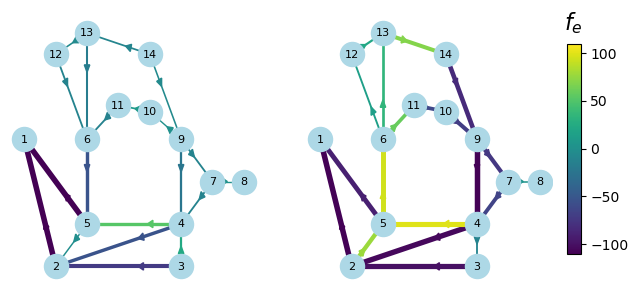

In [11]:
def compute_flows(theta, edges, Bvec):
    return np.array([
        Bvec[e] * np.sin(theta[u - 1] - theta[v - 1])
        for e, (u, v) in enumerate(edges)
    ])

def plot_line_flows_on_axis(G, positions, flows, ax, max_flow=None, title=''):
    if max_flow is None:
        max_flow = max(np.abs(flows)) + 1e-6

    norm = mpl.colors.Normalize(vmin=-max_flow, vmax=max_flow)
    cmap = plt.cm.viridis
    edge_colors = [cmap(norm(f)) for f in flows]
    edge_widths = [1.0 + 3.0 * abs(f) / max_flow for f in flows]

    nx.draw_networkx_nodes(G, pos=positions, node_color='lightblue', node_size=300, ax=ax)
    nx.draw_networkx_labels(G, pos=positions, font_size=8, ax=ax)

    # Draw edges with color and width, plus arrows for flow direction
    for ((u, v), flow, color, width) in zip(edges, flows, edge_colors, edge_widths):
        # Draw main edge line without arrow
        nx.draw_networkx_edges(G, pos=positions, edgelist=[(u, v)], edge_color=[color], width=width, ax=ax)

        # Draw arrow along the edge to indicate flow direction
        x_start, y_start = positions[u]
        x_end, y_end = positions[v]

        # Calculate vector for arrow
        dx = x_end - x_start
        dy = y_end - y_start

        # Normalize vector length for arrow size
        length = np.sqrt(dx**2 + dy**2)
        if length == 0:
            continue

        dx_norm = dx / length
        dy_norm = dy / length

        # Arrow points in direction of positive flow (from u to v if flow > 0, else reversed)
        arrow_length = 0.35 
        head_width = 0.35    
        head_length = 0.35  
        # Arrow points in direction of positive flow (from u to v if flow > 0, else reversed)
        if flow >= 0:
            arrow_start = (x_start + 0.3 * dx, y_start + 0.3 * dy)
            arrow_dx = arrow_length * dx_norm
            arrow_dy = arrow_length * dy_norm
        else:
            arrow_start = (x_end - 0.3 * dx, y_end - 0.3 * dy)
            arrow_dx = -arrow_length * dx_norm
            arrow_dy = -arrow_length * dy_norm

        ax.arrow(arrow_start[0], arrow_start[1], arrow_dx, arrow_dy,
                 head_width=head_width, head_length=head_length,
                 fc=color, ec=color, length_includes_head=True)

    ax.set_title(title, fontsize=9)
    ax.axis('off')

    return norm, cmap


stable_sols = [theta_solutions[i] for i in stable_indices]
flows_list = [compute_flows(theta, edges, Bvec) for theta in stable_sols]
global_max_flow = max(max(abs(flow)) for flow in flows_list)

fig_width = 7  
fig_height = 3.5
fig, axs = plt.subplots(1, len(stable_sols), figsize=(fig_width, fig_height))

if len(stable_sols) == 1:
    axs = [axs]

for ax, theta, flows, idx in zip(axs, stable_sols, flows_list, stable_indices):
    plot_line_flows_on_axis(G, positions, flows, ax, max_flow=global_max_flow) #, title=f"Stable Solution {idx+1}")

# Add colorbar axis on right
cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6]) 

norm = mpl.colors.Normalize(vmin=-global_max_flow, vmax=global_max_flow)
sm = mpl.cm.ScalarMappable(cmap=plt.cm.viridis, norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, cax=cbar_ax, orientation='vertical')
cbar.ax.set_title('$f_e$', fontsize=16, pad=10) 

plt.show()


We can find the cycle for which the winding numbers are different:

In [12]:
def wrap_to_pi(x):
    return (x + np.pi) % (2*np.pi) - np.pi  # (-pi, pi]

def winding_numbers(theta, edges, C):
    dtheta = np.array([theta[u-1] - theta[v-1] for (u, v) in edges])
    dtheta_wrapped = wrap_to_pi(dtheta)
    w = C.T @ dtheta_wrapped / (2*np.pi)
    return w, np.round(w).astype(int)

It turns out that for, fundamental cycle 6, the solutions differ between z=0 and z=1.

In [13]:
w, z = winding_numbers(theta_solutions[0], edges, C)
print("w (not rounded):", w)
print("z (rounded):", z)

w, z = winding_numbers(theta_solutions[1], edges, C)
print("w (not rounded):", w)
print("z (rounded):", z)

w (not rounded): [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -7.06789929e-17 -7.06789929e-17  0.00000000e+00]
z (rounded): [0 0 0 0 0 0 0]
w (not rounded): [-7.06789929e-17  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00]
z (rounded): [0 0 0 0 0 1 0]
